In [235]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 14})
import seaborn as sns

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

import warnings
warnings.filterwarnings('ignore')

#import natural language toolkit
import nltk

# download stopwords & punkt & VADER
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fajardirham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fajardirham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fajardirham/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [236]:
tweets_df = pd.read_csv('tweets.csv')
#movie_id is one above what it is supposed to be in movies_df
tweets_df['movie_id'] = tweets_df['movie_id'] - 1
tweets_df

,tweet,movie,movie_id
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0
...,...,...,...
801924,one minute into red rocket and I already know ...,Red Rocket,99
801925,Red Rocket was a wild dirty and cool movie. Si...,Red Rocket,99
801926,Honestly surprised Simon Rex is not getting mo...,Red Rocket,99
801927,Red Rocket is a good movie ❤️ https://t.co/TXz...,Red Rocket,99


In [237]:
movies_df = pd.read_csv('processed_movies.csv')
movies_df['Released'] = movies_df['Released'].apply(pd.to_datetime) #transforms our string values in column Released into a datetime object
movies_df.columns = ['released', 'movie', 'domestic', 'international', 'worldwide']
movies_df.head()

,released,movie,domestic,international,worldwide
0,2021-12-17,Spider-Man: No Way Home,"$804,617,772","$1,083,808,579","$1,888,426,351"
1,2021-09-03,Shang-Chi and the Legend of the Ten R…,"$224,543,292","$207,700,000","$432,243,292"
2,2021-10-01,Venom: Let There be Carnage,"$213,550,366","$288,050,013","$501,600,379"
3,2021-07-09,Black Widow,"$183,651,655","$196,100,000","$379,751,655"
4,2021-06-25,F9: The Fast Saga,"$173,005,945","$548,072,000","$721,077,945"


In [238]:
# Process the tweets first
def clean_text(text):
# Removes all special characters and numericals leaving the alphabets
    to_return = ''
    for word in text.split():
        if not '@' in word and not 'https:' in word:
            to_return += word + " "

    to_return = to_return.replace("#","")
    return to_return[0:len(to_return)-1]

test_clean = clean_text(tweets_df.iloc[0]['tweet'])
tweets_df["tweet_clean"] = tweets_df['tweet'].apply(clean_text)
tweets_df.head()

,tweet,movie,movie_id,tweet_clean
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...


In [239]:
# Tokenize
from nltk.tokenize import word_tokenize
tweets_df['tweet_token'] = tweets_df['tweet_clean'].apply(word_tokenize)
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp..."
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]"
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,..."


In [240]:
# Remove stop words

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tweets_df['tweet_stop'] = tweets_df['tweet_token'].apply(lambda x: [item for item in x if item not in stop_words])
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token,tweet_stop
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp...","[SpiderMan, saved, movie, going, experience, !..."
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with...","[Yes-, good, !, Grab, extra, napkins, popcorn,..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ...","[“, Spider, Man, trailer, stock, prices, ”, …,..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]",[obsessed]
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,...","[Looking, forward, Spider-Man, tonight, ., If,..."


In [241]:
# Stemming
from nltk.stem import PorterStemmer

ps = PorterStemmer()

tweets_df['tweet_stem'] = tweets_df['tweet_stop'].apply(lambda x: [ps.stem(y) for y in x])
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token,tweet_stop,tweet_stem
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp...","[SpiderMan, saved, movie, going, experience, !...","[spiderman, save, movi, go, experi, !, !, !]"
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with...","[Yes-, good, !, Grab, extra, napkins, popcorn,...","[yes-, good, !, grab, extra, napkin, popcorn, ..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ...","[“, Spider, Man, trailer, stock, prices, ”, …,...","[“, spider, man, trailer, stock, price, ”, …, ..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]",[obsessed],[obsess]
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,...","[Looking, forward, Spider-Man, tonight, ., If,...","[look, forward, spider-man, tonight, ., if, an..."


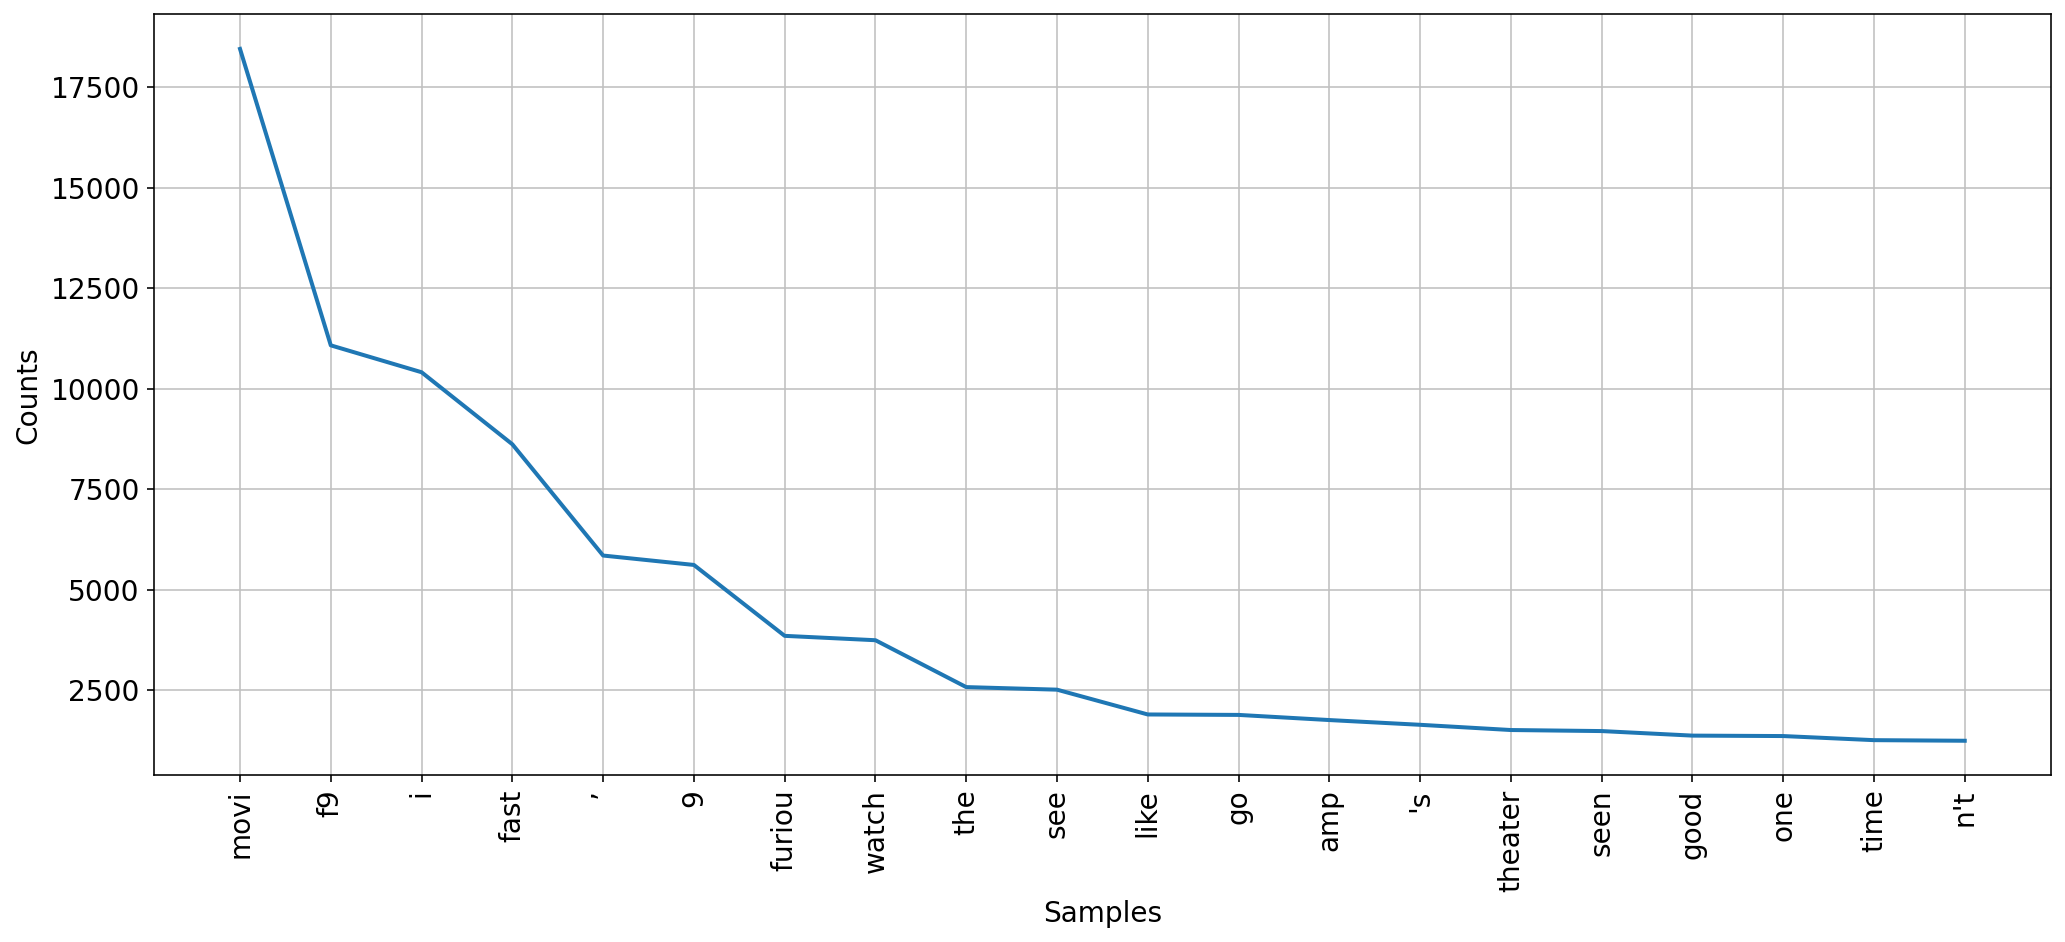

In [242]:
# get words after stemming
bw_tweets = tweets_df[tweets_df['movie'] == 'F9: The Fast Saga']
tweet_series = bw_tweets.squeeze()
tweet_stem = tweet_series['tweet_stem'].apply(pd.Series).stack()

from nltk.probability import FreqDist
import string

#calculate word frequency
fdist_tweets = FreqDist(tweet_stem)
#delete punctuation counts
for punc in string.punctuation:
    del fdist_tweets[punc]

#get top 20 words
fdist_tweets.plot(20, cumulative=False);

In [243]:
bw_tweets = tweets_df[tweets_df['movie'] == 'Black Widow']

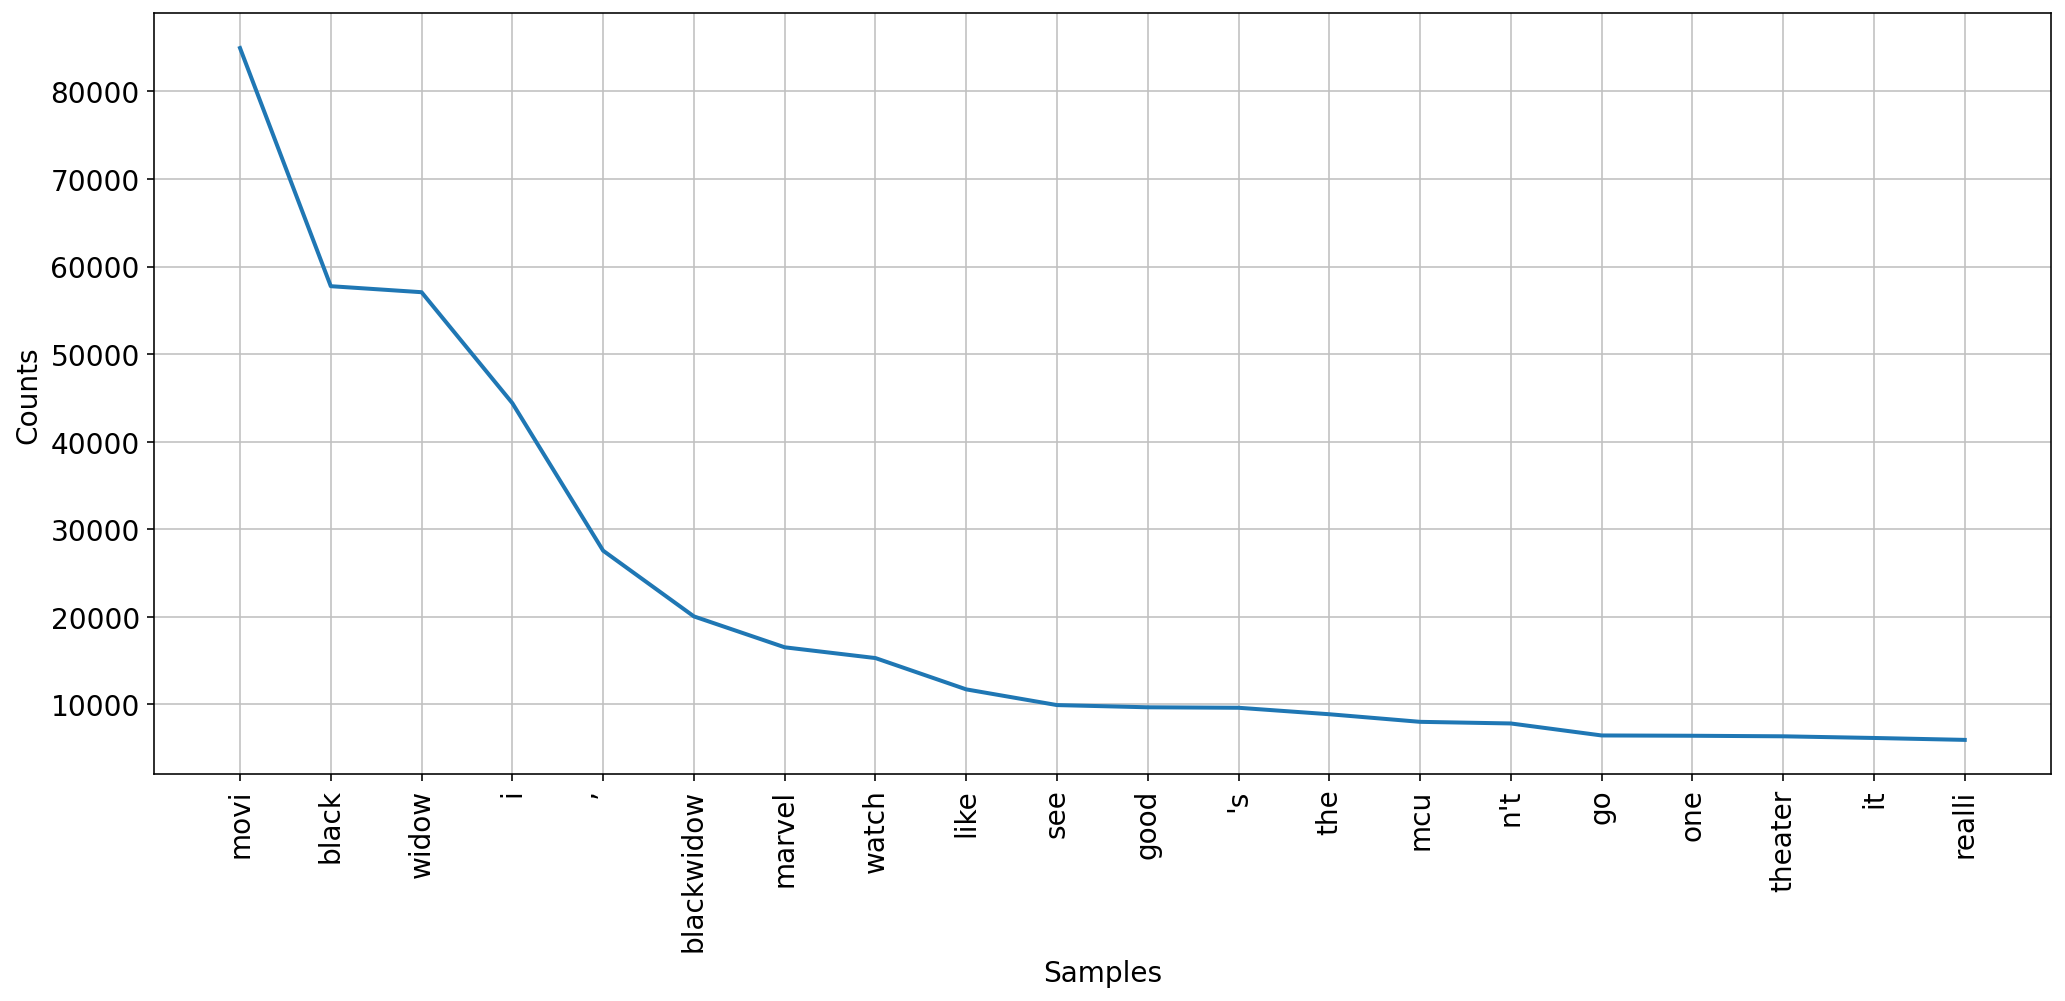

In [244]:
# get words after stemming
bw_tweets = tweets_df[tweets_df['movie'] == 'Black Widow']
tweet_series = bw_tweets.squeeze()
tweet_stem = tweet_series['tweet_stem'].apply(pd.Series).stack()

from nltk.probability import FreqDist
import string

#calculate word frequency
fdist_tweets = FreqDist(tweet_stem)
#delete punctuation counts
for punc in string.punctuation:
    del fdist_tweets[punc]

#get top 20 words
fdist_tweets.plot(20, cumulative=False);

In [245]:
# VADER sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyser = SentimentIntensityAnalyzer()
test_tweet = tweets_df.iloc[0]['tweet_clean']
print(test_tweet)
print(analyser.polarity_scores(test_tweet))

SpiderMan has saved the movie going experience!!!
{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.5684}


In [246]:
sentiment_df = pd.DataFrame()
sentiment_df['movie_id'] = tweets_df['movie_id']
sentiment_df['tweet_clean'] = tweets_df['tweet_clean']
sentiment_df['sentiment'] = tweets_df['tweet_clean'].apply(analyser.polarity_scores)
sentiment_df.head()

,tweet_clean,sentiment
0,SpiderMan has saved the movie going experience!!!,"{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compou..."
1,Yes- so good! Grab extra napkins with your pop...,"{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compou..."
2,“Spider Man trailer and stock prices”… Story |...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,too obsessed,"{'neg': 0.63, 'neu': 0.37, 'pos': 0.0, 'compou..."
4,Looking forward to Spider-Man tonight. If anyo...,"{'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compou..."


In [247]:
def spread_sentiment(sentiment_obj, category):
    return sentiment_obj[category]
sentiment_df['compound'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'compound'))
sentiment_df['neg'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'neg'))
sentiment_df['neu'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'neu'))
sentiment_df['pos'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'pos'))
sentiment_df.drop(columns=['sentiment'], inplace=True)
sentiment_df.head()

,tweet_clean,compound,neg,neu,pos
0,SpiderMan has saved the movie going experience!!!,0.5684,0.00,0.62,0.38
1,Yes- so good! Grab extra napkins with your pop...,0.7339,0.00,0.66,0.34
2,“Spider Man trailer and stock prices”… Story |...,0.0000,0.00,1.00,0.00
3,too obsessed,-0.1779,0.63,0.37,0.00
4,Looking forward to Spider-Man tonight. If anyo...,-0.6875,0.25,0.75,0.00


In [249]:
# group by and mean compound scores
grouped = sentiment_df.groupby(by=['movie_id'])
mean_sentiment_df = grouped.mean()
mean_sentiment_df.head()

,compound,neg,neu,pos
movie_id,,,,
0,0.181999,0.082796,0.749815,0.149046
1,0.397125,0.055206,0.725753,0.219045
2,0.189185,0.064801,0.773404,0.145460
3,0.264739,0.064517,0.769794,0.165674
4,0.032851,0.106320,0.775909,0.117712


In [250]:
# get number of tweets per movie
count_sentiment_df = grouped.count()
movie_aggregate_df = mean_sentiment_df.merge(count_sentiment_df['tweet_clean'], left_index=True, right_on='movie_id')
movie_aggregate_df.columns = ['compound_mean', 'neg_mean', 'neu_mean', 'pos_mean', 'num_tweets']
movie_aggregate_df.head(10)

,compound_mean,neg_mean,neu_mean,pos_mean,num_tweets
movie_id,,,,,
0,0.181999,0.082796,0.749815,0.149046,127734
1,0.397125,0.055206,0.725753,0.219045,21823
2,0.189185,0.064801,0.773404,0.145460,56743
3,0.264739,0.064517,0.769794,0.165674,75414
4,0.032851,0.106320,0.775909,0.117712,16604
6,0.334896,0.044007,0.768787,0.187207,5910
7,-0.300772,0.225089,0.669063,0.105848,10392
8,0.193592,0.065213,0.803856,0.130930,11077
9,0.310652,0.056961,0.767236,0.170980,25526


In [251]:
# join with box office
joined_df = movie_aggregate_df.merge(movies_df, left_on='movie_id', right_index=True)
joined_df.head(10)

,compound_mean,neg_mean,neu_mean,pos_mean,num_tweets,released,movie,domestic,international,worldwide
movie_id,,,,,,,,,,
0,0.181999,0.082796,0.749815,0.149046,127734,2021-12-17,Spider-Man: No Way Home,"$804,617,772","$1,083,808,579","$1,888,426,351"
1,0.397125,0.055206,0.725753,0.219045,21823,2021-09-03,Shang-Chi and the Legend of the Ten R…,"$224,543,292","$207,700,000","$432,243,292"
2,0.189185,0.064801,0.773404,0.145460,56743,2021-10-01,Venom: Let There be Carnage,"$213,550,366","$288,050,013","$501,600,379"
3,0.264739,0.064517,0.769794,0.165674,75414,2021-07-09,Black Widow,"$183,651,655","$196,100,000","$379,751,655"
4,0.032851,0.106320,0.775909,0.117712,16604,2021-06-25,F9: The Fast Saga,"$173,005,945","$548,072,000","$721,077,945"
6,0.334896,0.044007,0.768787,0.187207,5910,2021-12-22,Sing 2,"$162,790,990","$234,806,442","$397,597,432"
7,-0.300772,0.225089,0.669063,0.105848,10392,2021-10-08,No Time to Die,"$160,891,007","$600,511,039","$761,402,046"
8,0.193592,0.065213,0.803856,0.130930,11077,2021-05-28,A Quiet Place: Part II,"$160,215,764","$136,451,825","$296,667,589"
9,0.310652,0.056961,0.767236,0.170980,25526,2021-11-19,Ghostbusters: Afterlife,"$129,360,575","$75,261,116","$204,621,691"


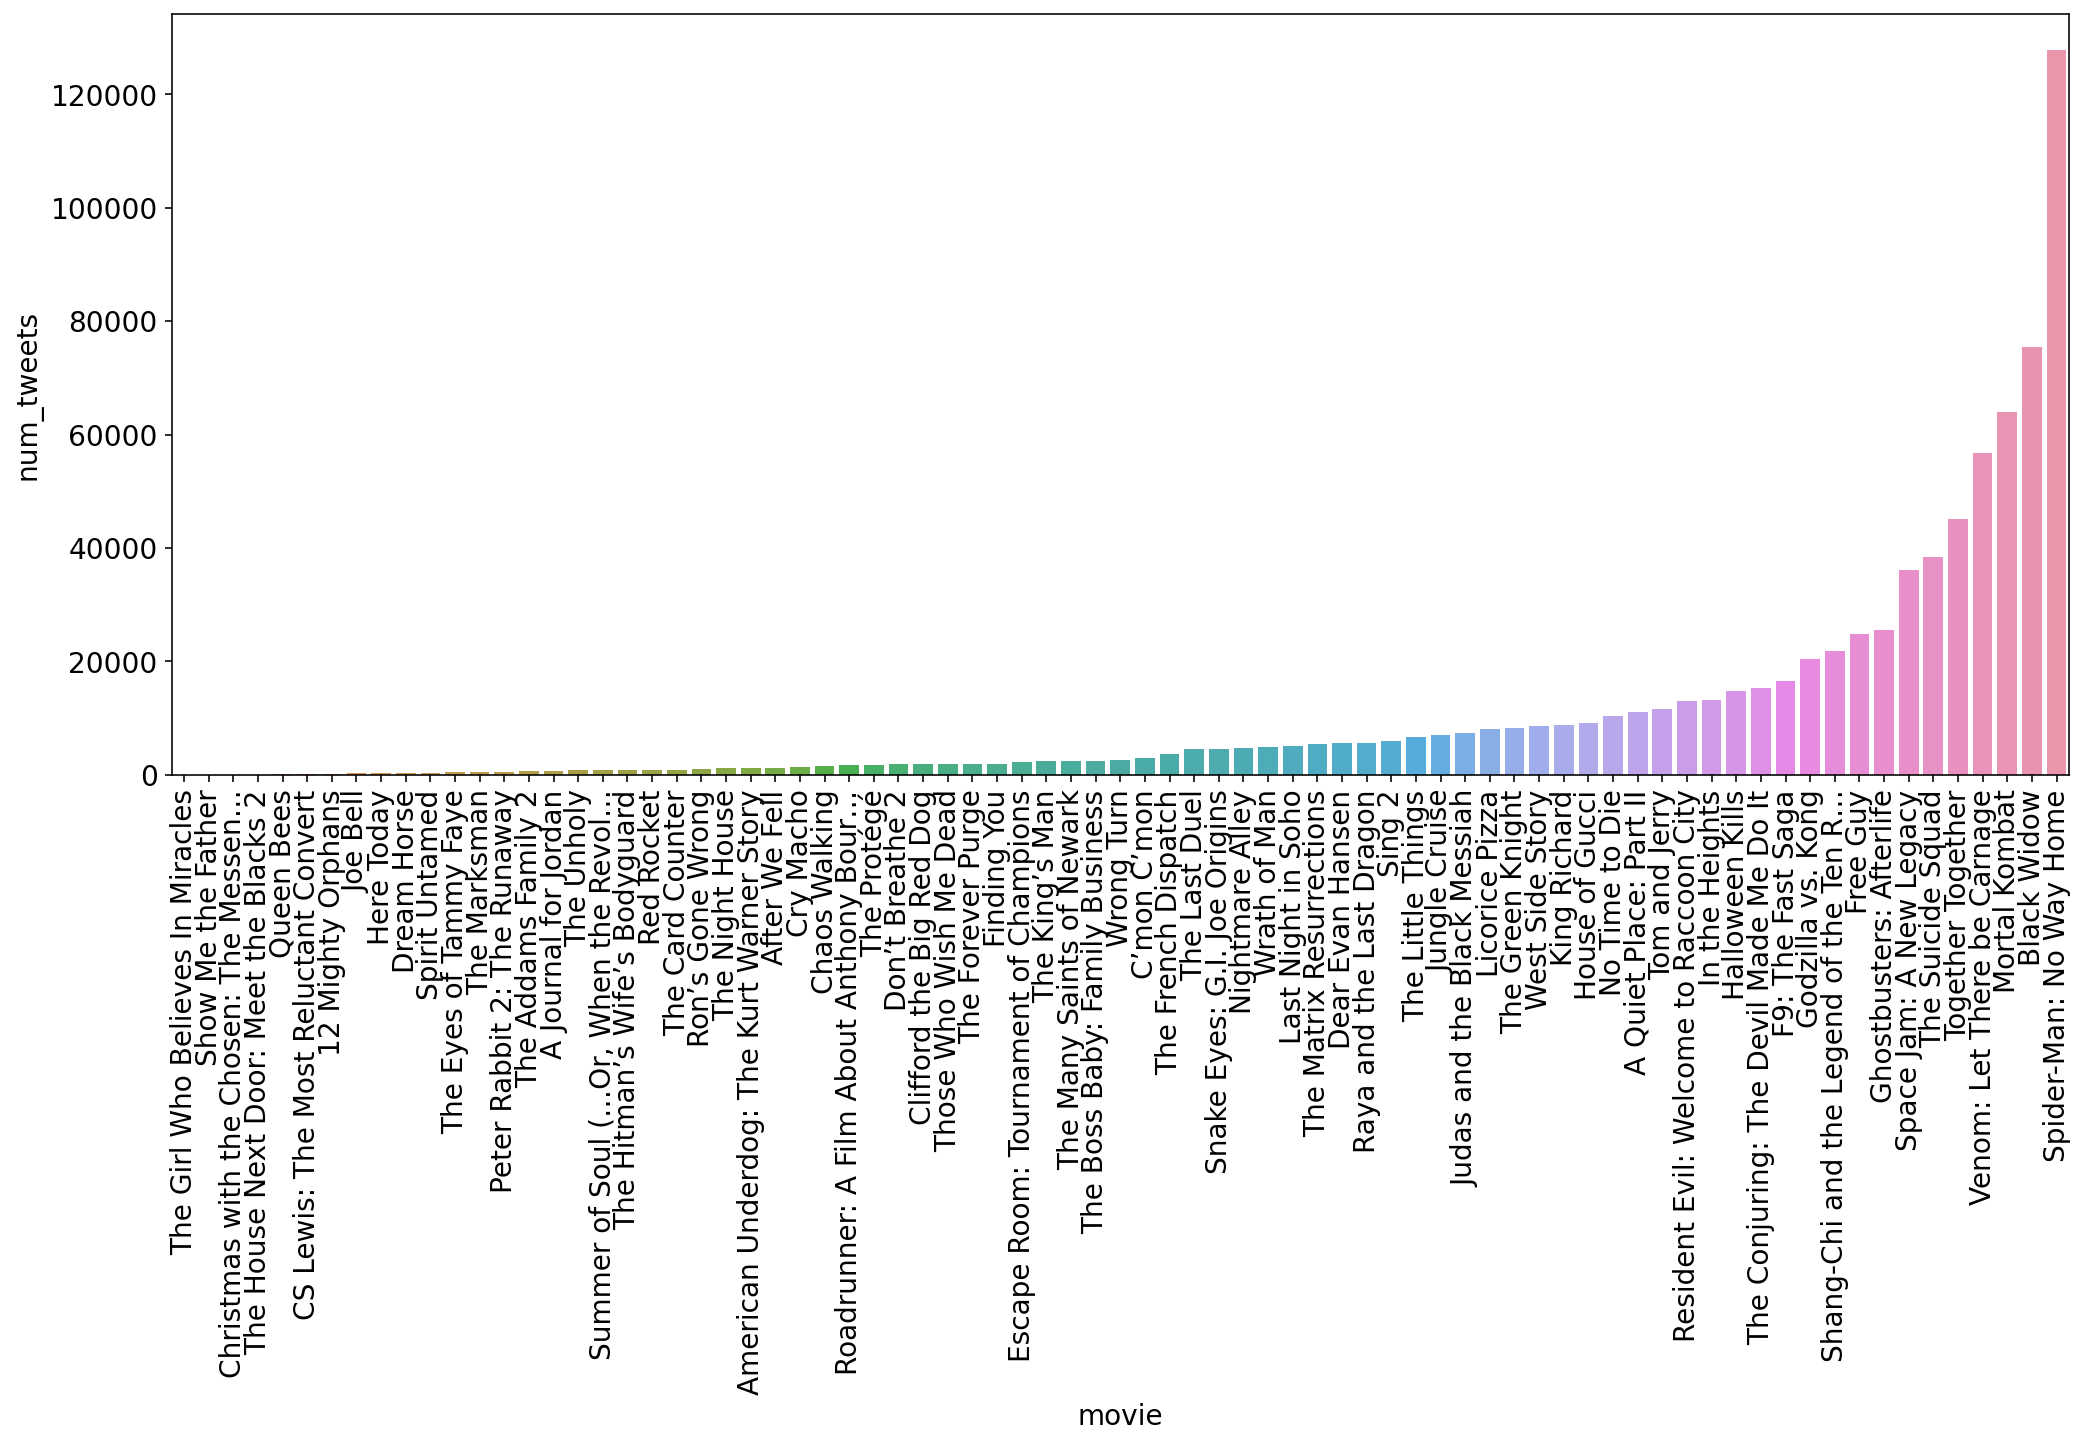

In [252]:
# Plot tweet counts
sorted_count_df = joined_df.sort_values(by='num_tweets', ascending=True)
sorted_count_plot = sns.barplot(data=sorted_count_df, y='num_tweets', x='movie')
for item in sorted_count_plot.get_xticklabels():
    item.set_rotation(90)

In [253]:
# Describe num tweets
joined_df.describe()

,compound_mean,neg_mean,neu_mean,pos_mean,num_tweets
count,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.192269,0.074978,0.779865,0.144078,10414.662338
std,0.187281,0.054764,0.058678,0.038554,19942.205932
min,-0.327764,0.011429,0.606001,0.083398,55.000000
25%,0.135932,0.047170,0.762692,0.117938,894.000000
50%,0.208534,0.058634,0.795419,0.136160,2688.000000
75%,0.310652,0.075939,0.815883,0.152480,9152.000000
max,0.601167,0.245268,0.866928,0.298729,127734.000000


We need to get rid of some outliers and low tweet counts to make our predictions more accurate.

(54, 10)
          compound_mean  neg_mean  neu_mean  pos_mean  num_tweets   released  \
movie_id                                                                       
1              0.397125  0.055206  0.725753  0.219045       21823 2021-09-03   
2              0.189185  0.064801  0.773404  0.145460       56743 2021-10-01   
3              0.264739  0.064517  0.769794  0.165674       75414 2021-07-09   
4              0.032851  0.106320  0.775909  0.117712       16604 2021-06-25   
6              0.334896  0.044007  0.768787  0.187207        5910 2021-12-22   

                                           movie      domestic international  \
movie_id                                                                       
1         Shang-Chi and the Legend of the Ten R…  $224,543,292  $207,700,000   
2                    Venom: Let There be Carnage  $213,550,366  $288,050,013   
3                                    Black Widow  $183,651,655  $196,100,000   
4                             

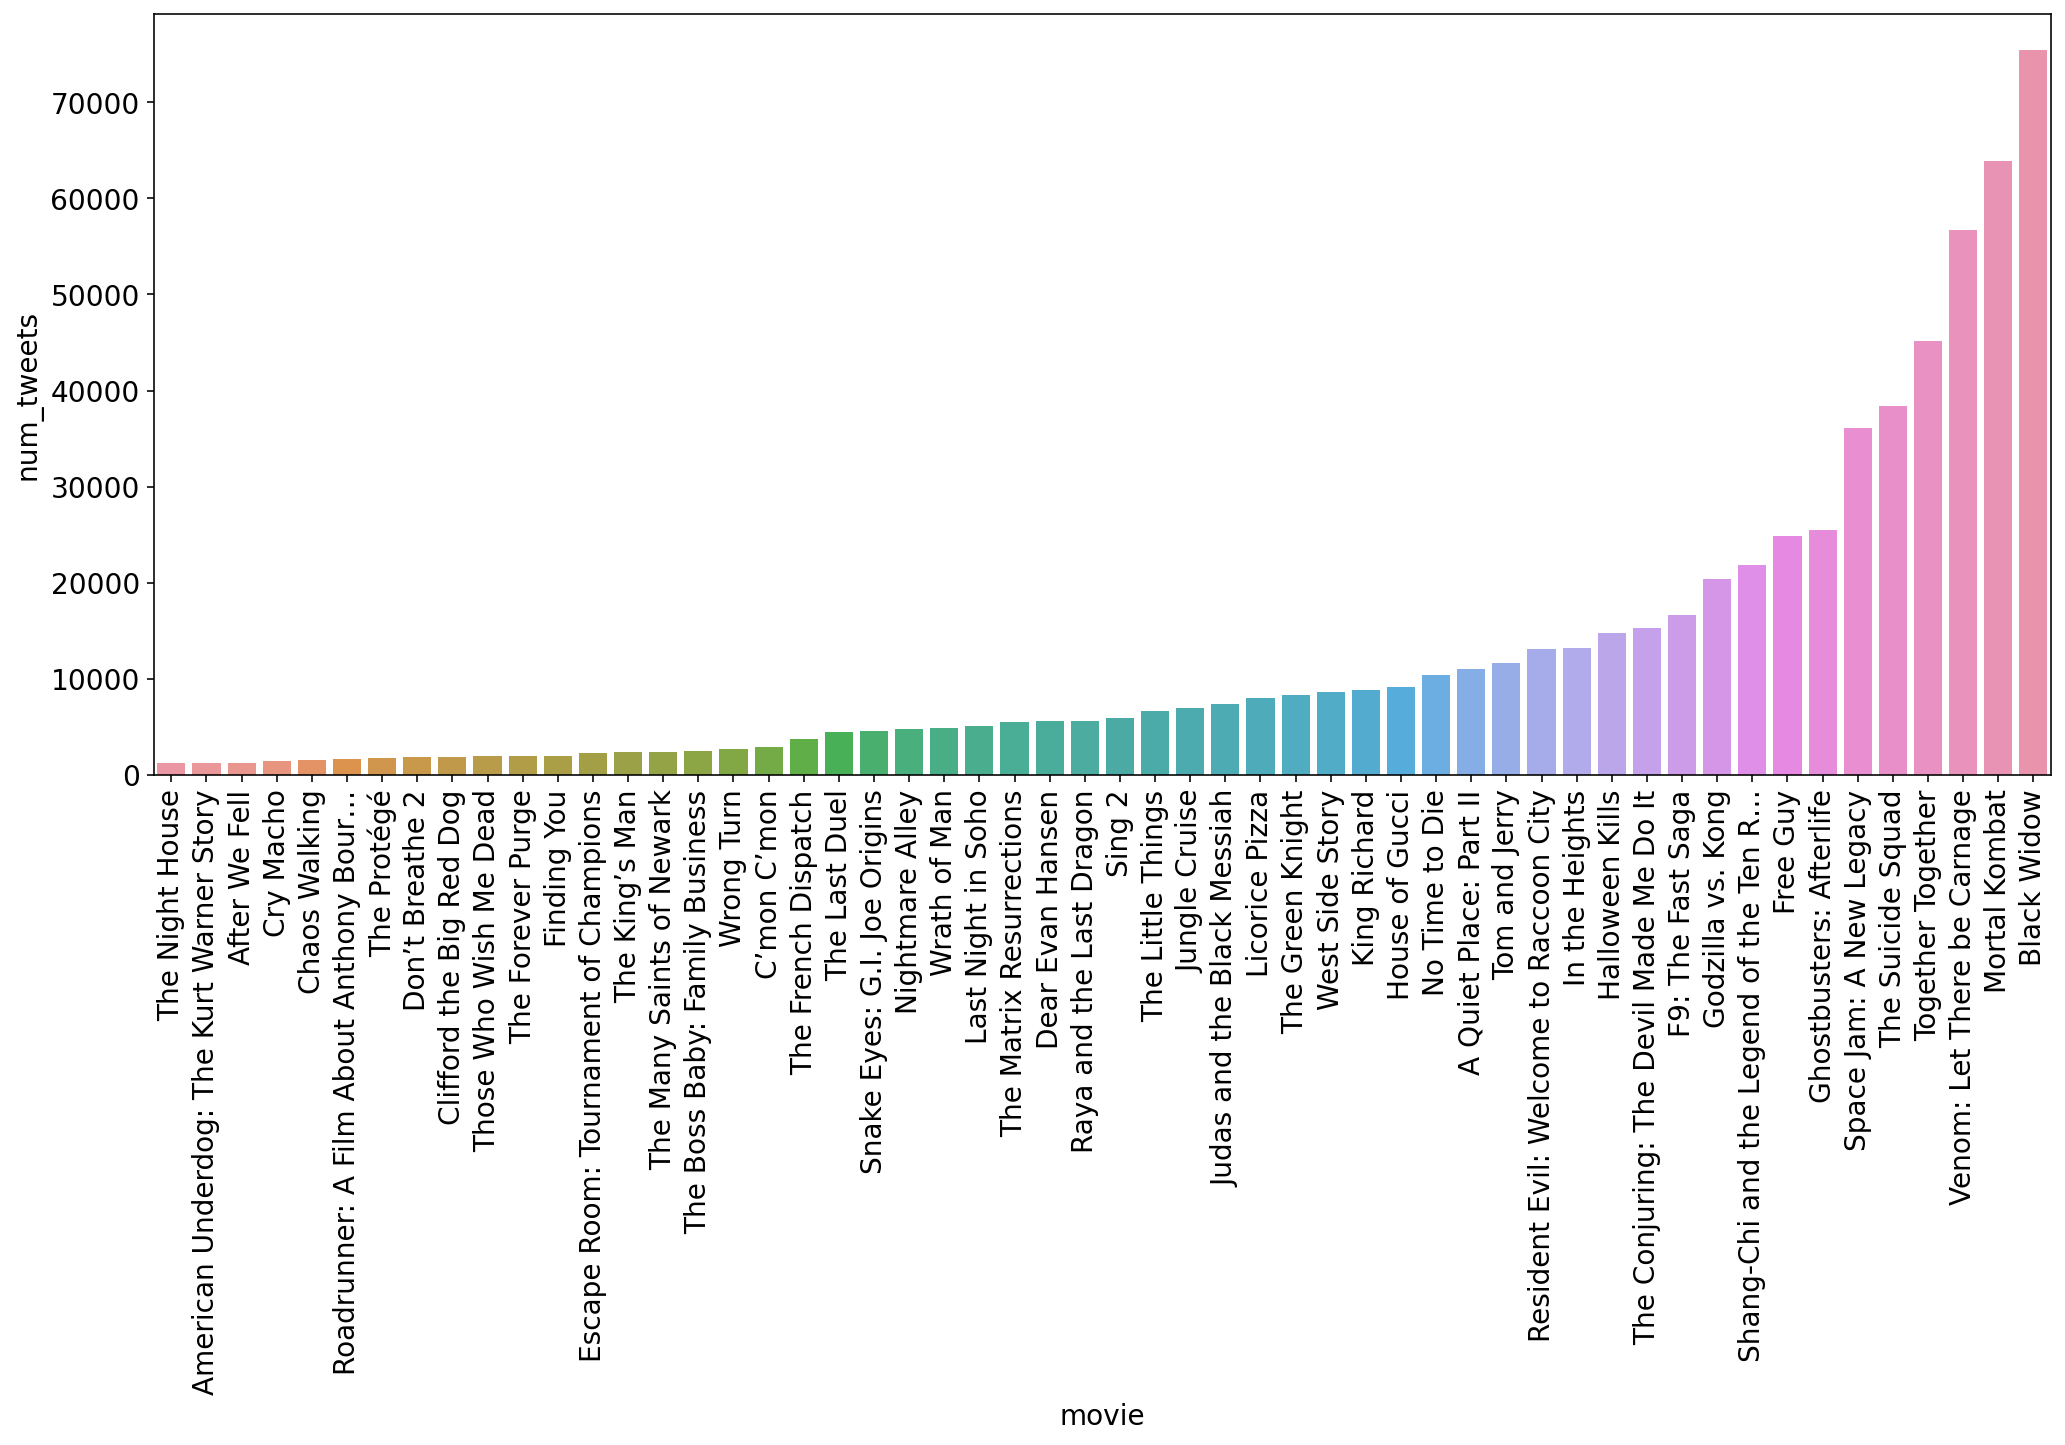

In [254]:
# To remove low count tweets for correlation, we will use movies with 1000 tweets or above
full_joined_df = joined_df
joined_df = joined_df[joined_df['num_tweets'] > 1000]

# Remove spider man
joined_df = joined_df[joined_df['num_tweets'] < 100000]

print(joined_df.shape)
print(joined_df.head())

sorted_count_df = joined_df.sort_values(by='num_tweets', ascending=True)
sorted_count_plot = sns.barplot(data=sorted_count_df, y='num_tweets', x='movie')
for item in sorted_count_plot.get_xticklabels():
    item.set_rotation(90)

### Connections between Average Compound Scores and Domestic Box Office

Let's see if there is a direct connection between average compound scores and domestic box office numbers

In [255]:
def std_cash(string):
    string = string.replace('$','').replace(',','')
    return float(string)

correlation_df = pd.DataFrame()
correlation_df['compound'] = joined_df['compound_mean']
correlation_df['domestic'] = joined_df['domestic'].apply(std_cash)
correlation_df.head()

,compound,domestic
movie_id,,
1,0.397125,224543292.0
2,0.189185,213550366.0
3,0.264739,183651655.0
4,0.032851,173005945.0
6,0.334896,162790990.0


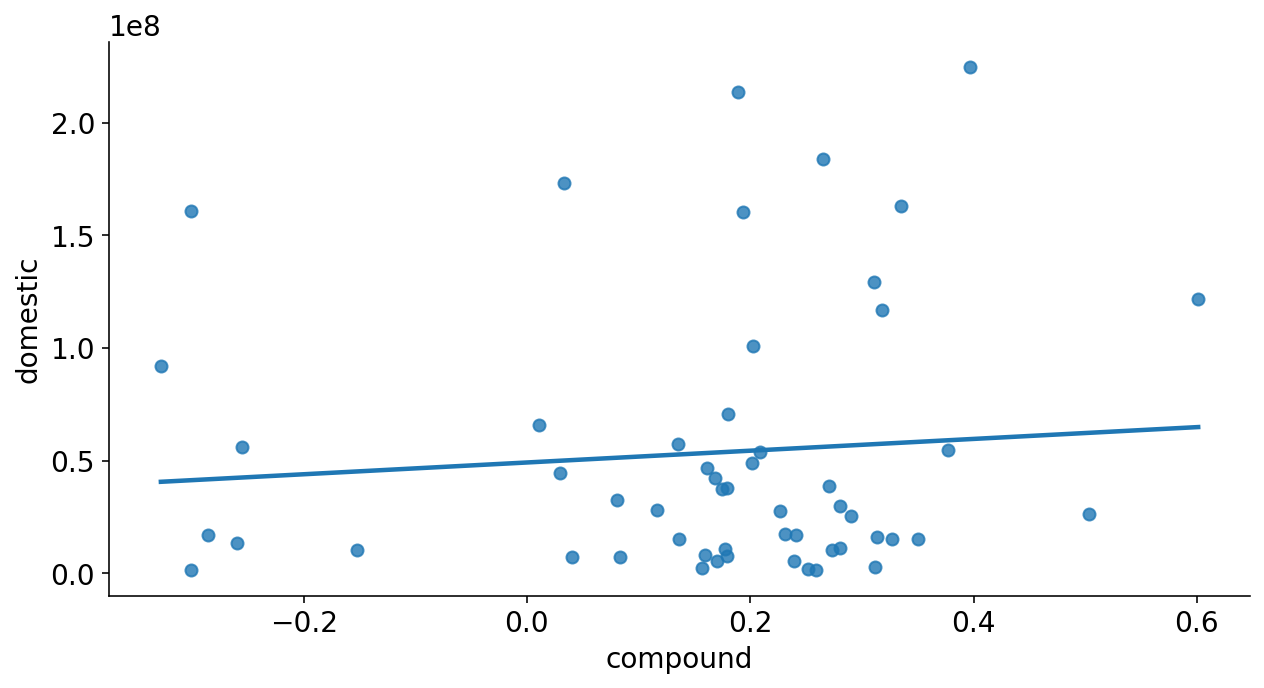

In [256]:
sns.lmplot(x='compound', y='domestic', data=correlation_df, ci=None, aspect=1.8)

In [257]:
outcome, predictors = patsy.dmatrices('domestic ~ compound', correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.4023
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.529
Time:                        21:28:32   Log-Likelihood:                -1042.9
No. Observations:                  54   AIC:                             2090.
Df Residuals:                      52   BIC:                             2094.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.916e+07   1.06e+07      4.656      0.0

#### Conclusion
There does not seem to be a direct correlation between average compound scores of tweets 2 months after release and domestic box office numbers. This is evident from the relatively high p value for our predictor number and low R squared, indicated that the pearson correlation number is low.

### Correlation Between Movie Tweet Count & Domestic Box Office

In [271]:
correlation_df['num_tweets'] = joined_df['num_tweets']
correlation_df.head(10)

,compound,domestic,num_tweets,log_tweets
movie_id,,,,
1,0.397125,224543292.0,21823,9.990720
2,0.189185,213550366.0,56743,10.946288
3,0.264739,183651655.0,75414,11.230748
4,0.032851,173005945.0,16604,9.717399
6,0.334896,162790990.0,5910,8.684401
7,-0.300772,160891007.0,10392,9.248792
8,0.193592,160215764.0,11077,9.312626
9,0.310652,129360575.0,25526,10.147453
10,0.601167,121626598.0,24851,10.120653


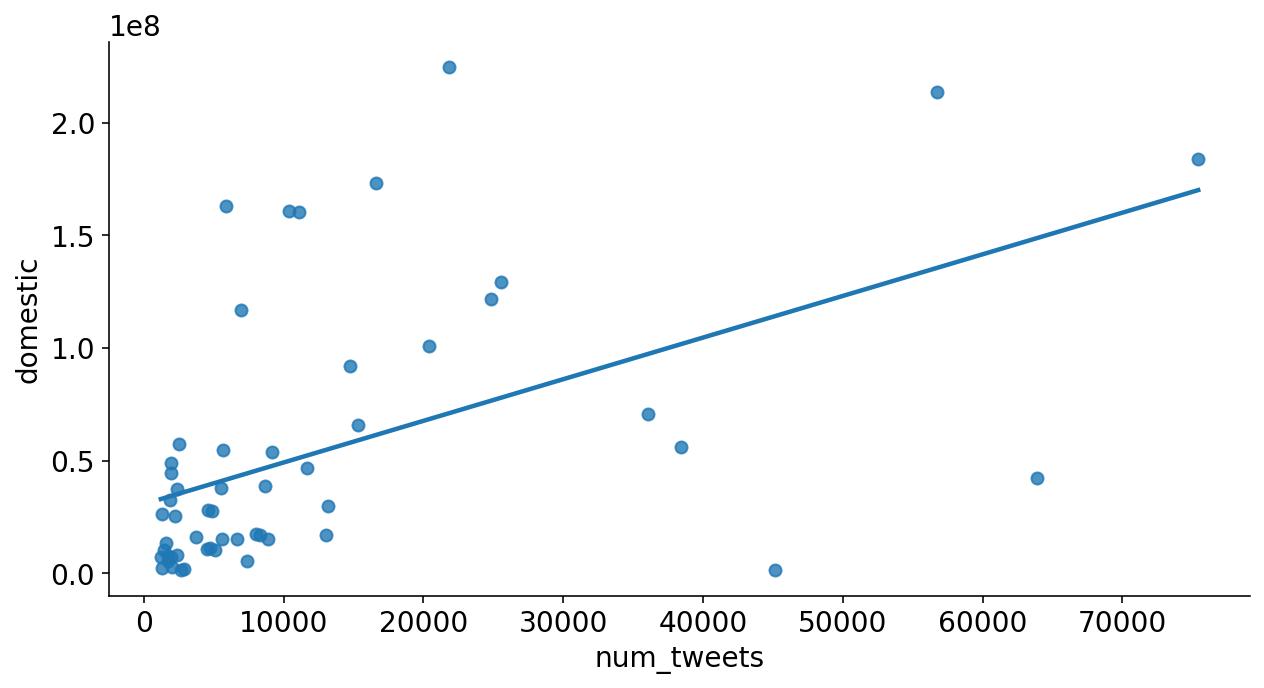

In [273]:
sns.lmplot(x='num_tweets', y='domestic', data=correlation_df,
          ci=None, aspect=1.8)

In [260]:
outcome, predictors = patsy.dmatrices('domestic ~ num_tweets', correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     17.70
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           0.000103
Time:                        21:28:47   Log-Likelihood:                -1035.2
No. Observations:                  54   AIC:                             2074.
Df Residuals:                      52   BIC:                             2078.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.067e+07   8.92e+06      3.440      0.0

#### Conclusion
There does seem to be a linear relationship between the number of tweets and domestic box office numbers. The p value for the predictor is low and the pearson coefficient squared seems to be high enough to suggest a positive correlation (R^2 = 0.25 -> R = 0.5). The OLS model suggests that for every tweet, box office numbers would increase by $1847.

Realistically, this makes some sense. Assuming it costs $10 for each movie ticket, $1847 would equal to about 184 people buying tickets for a movie. It is within the realm of possibility that only one out of 184 people would tweet about a movie they have seen.

### Correlation Between Tweet Count of Differing Sentiments & Domestic Box Office 

First we will add labels to our tweets (pos, neg, and neu). Then we will add up the number of labels per movie. Then we will see if there is a correlation between the number of labeled tweets.

In [261]:
def compound_to_label(compound_score):
    if(compound_score >= 0.05): return 'pos'
    if(compound_score <= -0.05): return 'neg'
    return 'neu'

sentiment_df['label'] = sentiment_df['compound'].apply(compound_to_label)
sentiment_df.head(10)

,tweet_clean,compound,neg,neu,pos,movie_id,label
0,SpiderMan has saved the movie going experience!!!,0.5684,0.00,0.620,0.380,0,pos
1,Yes- so good! Grab extra napkins with your pop...,0.7339,0.00,0.660,0.340,0,pos
2,“Spider Man trailer and stock prices”… Story |...,0.0000,0.00,1.000,0.000,0,neu
3,too obsessed,-0.1779,0.63,0.370,0.000,0,neg
4,Looking forward to Spider-Man tonight. If anyo...,-0.6875,0.25,0.750,0.000,0,neg
5,because it’s a marvel movie and nwh proved tha...,0.4215,0.00,0.833,0.167,0,pos
6,One of the best spider man movie ✨✨✨,0.6369,0.00,0.625,0.375,0,pos
7,Like you said thanks for giving the movie your...,0.3753,0.05,0.835,0.115,0,pos
8,NWH = a Reboot Origin of all 6 Spideeman movie...,0.4019,0.00,0.920,0.080,0,pos
9,Top 10 movies of 2021: From Spider-Man to Dune...,0.2023,0.00,0.886,0.114,0,pos


In [262]:
pos_df = sentiment_df[sentiment_df['label'] == 'pos']
neu_df = sentiment_df[sentiment_df['label'] == 'neu']
neg_df = sentiment_df[sentiment_df['label'] == 'neg']


pos_grouped = pos_df.groupby(by=['movie_id'])
pos_count = pos_grouped.count()['tweet_clean']
neu_grouped = neu_df.groupby(by=['movie_id'])
neu_count = neu_grouped.count()['tweet_clean']
neg_grouped = neg_df.groupby(by=['movie_id'])
neg_count = neg_grouped.count()['tweet_clean']
labeled_count_df = pd.DataFrame()
labeled_count_df['pos_count'] = pos_count
labeled_count_df['neu_count'] = neu_count
labeled_count_df['neg_count'] = neg_count
labeled_count_df['num_tweets'] = labeled_count_df['pos_count'] + labeled_count_df['neu_count'] + labeled_count_df['neg_count']

# Remove outliers and low tweet counts
labeled_count_df = labeled_count_df[labeled_count_df['num_tweets'] > 1000]
labeled_count_df = labeled_count_df[labeled_count_df['num_tweets'] < 100000]

# Add domestic
labeled_count_df['domestic'] = correlation_df['domestic']

labeled_count_df.head(10)

,pos_count,neu_count,neg_count,num_tweets,domestic
movie_id,,,,,
1,15628,2727,3468,21823,224543292.0
2,28400,16377,11966,56743,213550366.0
3,45709,12976,16729,75414,183651655.0
4,7042,3303,6259,16604,173005945.0
6,3798,1231,881,5910,162790990.0
7,2576,463,7353,10392,160891007.0
8,5933,2409,2735,11077,160215764.0
9,15976,4602,4948,25526,129360575.0
10,21705,1463,1683,24851,121626598.0


                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     18.94
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           6.34e-05
Time:                        21:45:13   Log-Likelihood:                -1034.7
No. Observations:                  54   AIC:                             2073.
Df Residuals:                      52   BIC:                             2077.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.127e+07   8.68e+06      3.603      0.0

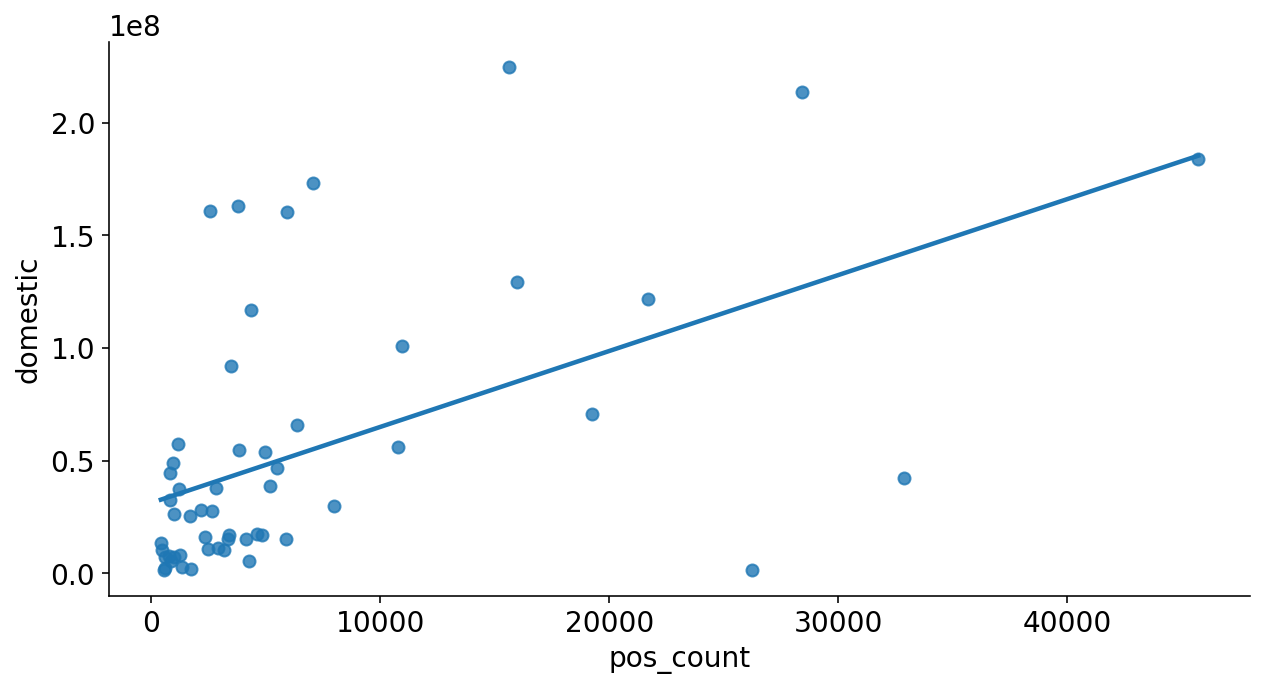

In [268]:
# plot pos
outcome, predictors = patsy.dmatrices('domestic ~ pos_count', labeled_count_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

sns.lmplot(x='pos_count', y='domestic', 
           data=labeled_count_df, ci=None, aspect=1.8)

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     13.34
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           0.000605
Time:                        21:48:41   Log-Likelihood:                -1036.9
No. Observations:                  54   AIC:                             2078.
Df Residuals:                      52   BIC:                             2082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    3.61e+07   8.72e+06      4.138      0.0

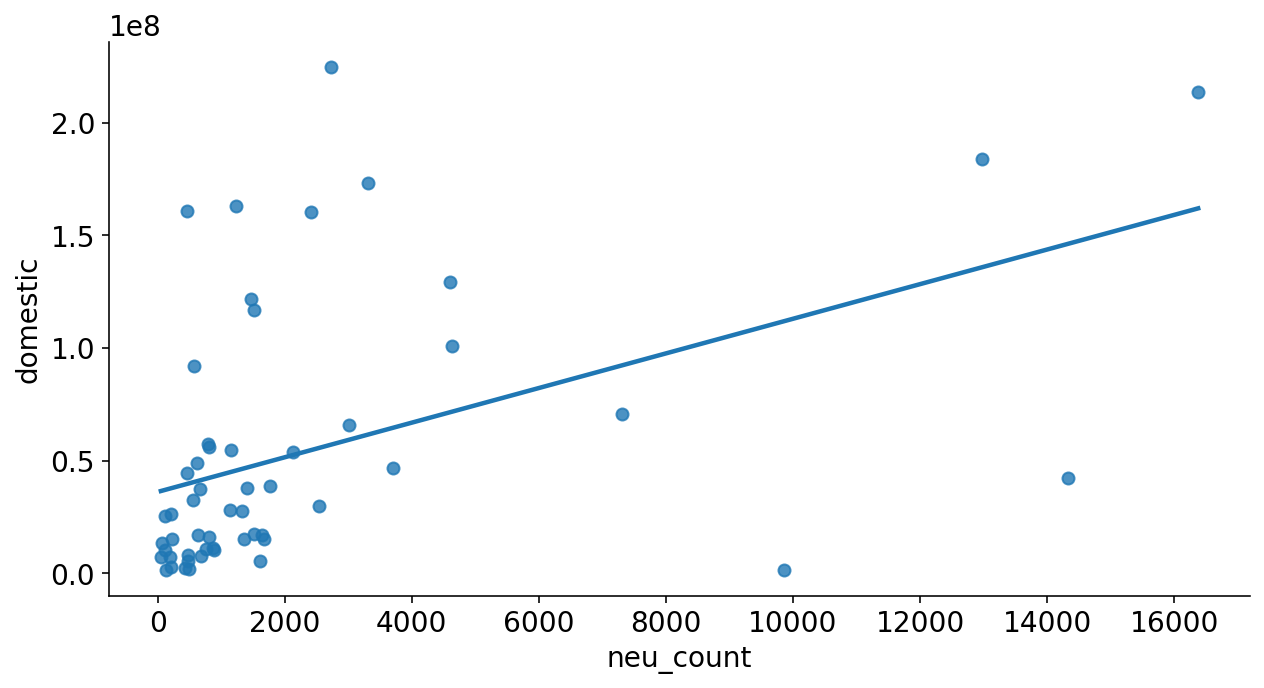

In [269]:
# plot neu
outcome, predictors = patsy.dmatrices('domestic ~ neu_count', labeled_count_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

sns.lmplot(x='neu_count', y='domestic', 
           data=labeled_count_df, ci=None, aspect=1.8)

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     8.187
Date:                Mon, 06 Jun 2022   Prob (F-statistic):            0.00606
Time:                        21:49:18   Log-Likelihood:                -1039.1
No. Observations:                  54   AIC:                             2082.
Df Residuals:                      52   BIC:                             2086.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.842e+07   9.26e+06      4.150      0.0

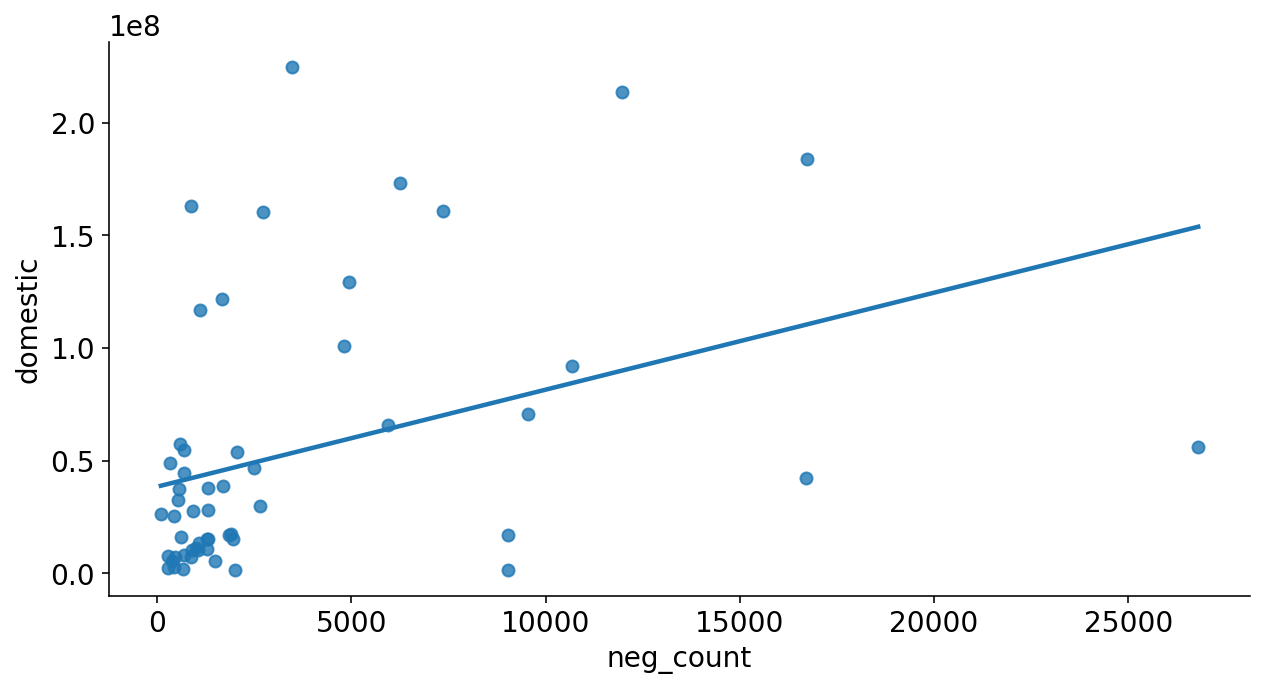

In [270]:
# plot neg
outcome, predictors = patsy.dmatrices('domestic ~ neg_count', labeled_count_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

sns.lmplot(x='neg_count', y='domestic', 
           data=labeled_count_df, ci=None, aspect=1.8)

### Notes
Just by looking at the graphs, the sentiments of the tweets do not matter as much as the more tweets generally equate to higher domestic box office numbers. We'll now use OLS to see how each of the labels correlate to the domestic numbers.

In [266]:
outcome, predictors = patsy.dmatrices('domestic ~ pos_count + neu_count + neg_count', labeled_count_df)
model = sm.OLS(outcome, predictors)
pos_results = model.fit()

print(pos_results.summary())

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     6.126
Date:                Mon, 06 Jun 2022   Prob (F-statistic):            0.00124
Time:                        21:30:31   Log-Likelihood:                -1034.6
No. Observations:                  54   AIC:                             2077.
Df Residuals:                      50   BIC:                             2085.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.079e+07   9.05e+06      3.403      0.0

### Notes
According to this OLS predictor, the amount of neutral

In [267]:
outcome, predictors = patsy.dmatrices('domestic ~ compound + num_tweets + compound*num_tweets', correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               domestic   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     6.049
Date:                Mon, 06 Jun 2022   Prob (F-statistic):            0.00135
Time:                        21:32:40   Log-Likelihood:                -1034.7
No. Observations:                  54   AIC:                             2077.
Df Residuals:                      50   BIC:                             2085.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            3.287e+07   1